# About Me
Hello all, I am Hasan and this is my first kernel. I'm still learning python and data science libraries. So your comments are extremely helpful to me. 

# Introduction
Turkey stands between Europe and Asia. Geographically country is rather young hence it is more sismographically active. I found this dataset on Kaggle which originates from Kandilli Rasathanesi which is a reputable organisation affiliated with Bogazici University. I will try to analyse the data and create some visualisations. 

In [22]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Data Cleaning

The dataset is in a txt file and whilst reading it, an encoding error has raised. I used *chardet* library to detect the encoding.

In [23]:
with open('data/datasetindex.txt', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(1000000))
    
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.729996595530351, 'language': ''}


As seen above encoding is *ISO-8859-1* on a confidence level of 73%. 

In [24]:
#reading the dataset
data = pd.read_table('data/datasetindex.txt', sep='\t', encoding='ISO-8859-1', index_col=0)
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24007 entries, 1 to 24007
Data columns (total 14 columns):
Deprem Kodu    24007 non-null int64
Olus tarihi    24007 non-null object
Olus zamani    24007 non-null object
Enlem          24007 non-null float64
Boylam         24007 non-null float64
Der(km)        24007 non-null float64
xM             24007 non-null float64
MD             24007 non-null float64
ML             24007 non-null float64
Mw             5003 non-null float64
Ms             24007 non-null float64
Mb             24007 non-null float64
Tip            24007 non-null object
Yer            24007 non-null object
dtypes: float64(9), int64(1), object(4)
memory usage: 2.7+ MB


,Deprem Kodu,Olus tarihi,Olus zamani,Enlem,Boylam,Der(km),xM,MD,ML,Mw,Ms,Mb,Tip,Yer
No,,,,,,,,,,,,,,
6,20170730175118,2017.07.30,17:51:18.76,37.0073,27.5977,11.2,4.6,0.0,4.5,4.6,0.0,0.0,Ke,GOKOVA KORFEZI (AKDENIZ)
21551,19690323210842,1969.03.23,21:08:42.10,39.1400,28.4800,9.0,5.9,5.7,5.8,5.9,5.9,5.6,Ke,BARDAKCI-DEMIRCI (MANISA) [North West 3.5 km]
583,20161226055331,2016.12.26,05:53:31.36,32.3707,30.9340,28.0,4.5,0.0,4.5,4.4,0.0,0.0,Ke,KIBRIS RUM KESIMI
23310,19350104144130,1935.01.04,14:41:30.40,40.4000,27.4900,30.0,6.4,6.1,6.0,6.2,6.4,6.0,Ke,ERDEK KÖRFEZI (MARMARA DENIZI)
1877,20140822071938,2014.08.22,07:19:38.77,39.9483,23.4110,22.7,3.6,0.0,3.6,NaN,0.0,0.0,Ke,YUNANISTAN


Above it is seen that the column names are in Turkish and the last column is partially in Turkish. I am translated them and replace the column names with their English equivalents. 

In [25]:
col_names = ['earthquake_code', 'date', 'time', 'latitude', 'longitude',
       'depth(km)', 'xM', 'MD', 'ML', 'Mw', 'Ms', 'Mb', 'type', 'location']
data.columns = col_names
data.head(3)

,earthquake_code,date,time,latitude,longitude,depth(km),xM,MD,ML,Mw,Ms,Mb,type,location
No,,,,,,,,,,,,,,
1,20170731212909,2017.07.31,21:29:09.17,34.1567,23.9122,16.2,5.3,0.0,5.3,0.0,0.0,0.0,Ke,GIRIT ADASI ACIKLARI (AKDENIZ)
2,20170731165754,2017.07.31,16:57:54.21,36.8987,27.5618,7.3,3.5,0.0,3.3,3.5,0.0,0.0,Ke,GOKOVA KORFEZI (AKDENIZ)
3,20170731162536,2017.07.31,16:25:36.10,36.9965,27.6207,7.8,4.0,0.0,3.8,4.0,0.0,0.0,Ke,GOKOVA KORFEZI (AKDENIZ)


Date and time are two different columns and they are not in *datetime* format. When I tried to convert them to datetime in one column, I recieved an error that there was a problem with seconds. One of the data point had higher than 59, which is impossible for a second. Below, you may see how I found that point and updated it. 

In [26]:
#There was a wrong data of seconds, updated that
sec_err = data['time'].str.extract(r'\:(\d+)\.')[0].apply(lambda x: int(x))
print(sec_err[sec_err>59])
data.loc[13080, 'time'] = '10:03:59.00'
print(sec_err[sec_err>59])

No    
13080    73
Name: 0, dtype: int64
No    
13080    73
Name: 0, dtype: int64


Since I eradicated the error I can now create one column of datetime and drop the others. 

In [27]:
data['date_time'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data = data.drop(['date', 'time'], axis=1)

Whilst checking the location column I realised there are other countries in the data. I cleared them out. 

In [28]:
countries = ['YUNANISTAN', 'GURCISTAN', 'RUSYA', 'IRAN', 'AZERBAYCAN', 'MAKEDONYA', 
             'BULGARISTAN', 'SURIYE', 'IRAK', 'ROMANYA', 'ARNAVUTLUK', 'MISIR', 
             'KIBRIS RUM KESIMI', 'UKRAYNA', 'YUNANiSTAN', 'iRAN', 'BULGARiSTAN',
             'GÜRCiSTAN', 'MISIR', 'SURiYE', 'ISRAIL', 'ONiKi ADALAR YUNANiSTAN',
             'KIBRIS RUM KESiMi']
for country in countries:
    data = data[data.location != country]
    
#delete the points out of Turkey's geolocation
data = data[data.latitude >= 36]
data = data[data.longitude >= 26]

The location data is very detailed and not structured. It shows the provinces and cities. City names are included generally in paranthesis. I am creating a new column showing only the city names. 

In [29]:
data['city'] = data['location'].str.extract(r'\((.+)\)')
data.city = data.city.fillna(data[data.city.isnull()].location)

Let's explore the data. Here is the 10 worst earthquakes of Turkey. The heaviest earthquate was occured in the city of Erzincan in 1939. 

In [30]:
data[['date_time', 'city', 'xM']].sort_values('xM', ascending=False).head(10)

,date_time,city,xM
No,,,
23196,1939-12-26 23:57:20.900,ERZINCAN,7.9
23636,1926-06-26 19:46:38.800,AKDENIZ,7.7
23467,1930-05-06 22:34:31.700,TÜRKIYE-IRAN SINIR BÖLGESI,7.6
19546,1976-11-24 12:22:16.000,VAN,7.5
10318,1999-08-17 00:01:37.600,KOCAELI,7.4
23994,1912-08-09 01:29:00.000,TEKIRDAG,7.3
23068,1944-02-01 03:22:39.900,KARABÜK,7.2
4048,2011-10-23 10:41:21.010,VAN,7.2
23078,1943-11-26 22:20:40.800,ÇANKIRI,7.2


# Visualisations

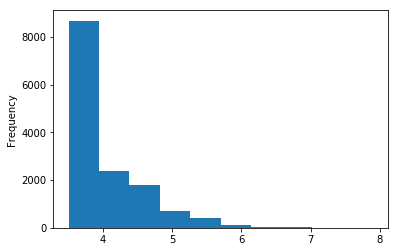

In [31]:
data.xM.plot.hist(bins=10)

The frequency of earthquakes are shown above. The most frequent eathquakes have a magnitude between 3 and 4. The Richter magnitude scale categorises earthquakes below 5 as minor. I plotted some non-minor insights below. The month of May is a bit unlucky, the most of the earthqaukes more than 5 happening on May. Also Wednesday is the most shakey day of the week. 

Text(0.5, 0, 'Days of the week')

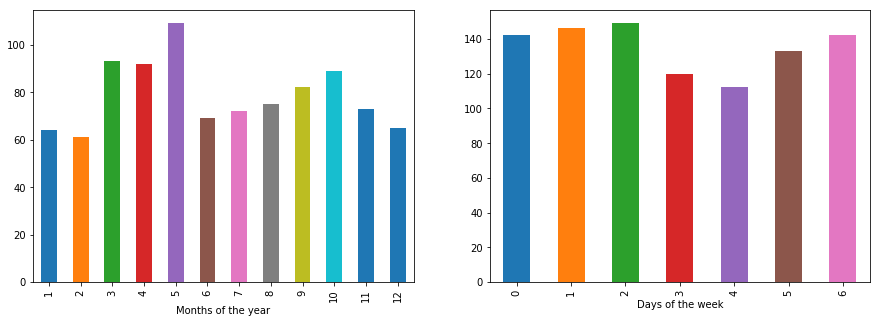

In [32]:
data['year'] = data.date_time.apply(lambda x: x.year)
data['month'] = data.date_time.apply(lambda x: x.month)
data['weekday'] = data.date_time.apply(lambda x: x.dayofweek)
dataover5 = data[data.xM >= 5]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
dataover5.month.value_counts().sort_index().plot.bar()
plt.xlabel('Months of the year')
plt.subplot(1,2,2)
dataover5.weekday.value_counts().sort_index().plot.bar()
plt.xlabel('Days of the week')

By looking all data, May is still the worst month of all, however, the most shakey day is Sunday. This refutes a popular Turkish pun 'Tuesday shakes' (Salı sallanır).  

Text(0.5, 0, 'Days of the week')

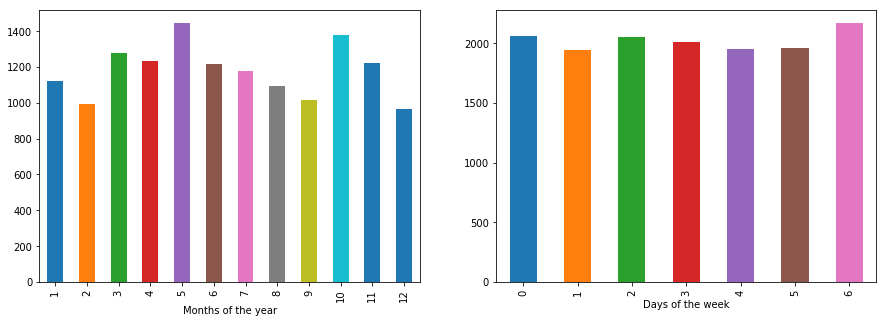

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
data.month.value_counts().sort_index().plot.bar()
plt.xlabel('Months of the year')
plt.subplot(1,2,2)
data.weekday.value_counts().sort_index().plot.bar()
plt.xlabel('Days of the week')


Below I plotted the frequency of the earthquakes by years. The graph on left shows the occurence of earthquakes are on an increasing trend. The occurences peak somewhere in 1970s, this probably means that there were new technologies to capture the data from then. The graph on the right shows the frequency of eathquakes with magnitude higher then 5. 

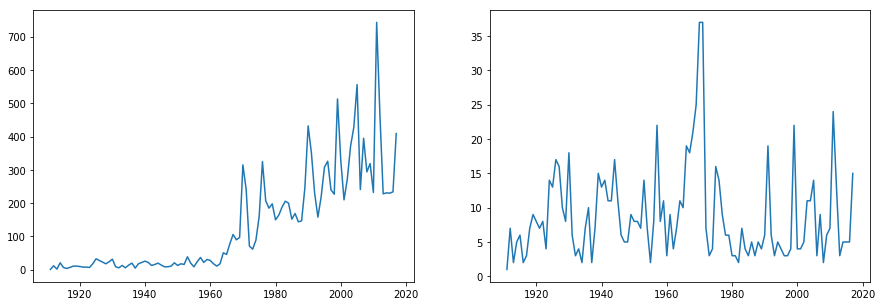

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(data.year.value_counts().sort_index())
plt.subplot(1,2,2)
plt.plot(data[data.xM >= 5].year.value_counts().sort_index())

The graphics above gives their trends differently by years. Below the total earthquakes and the ones more than 5 can be seen in the same graph. 

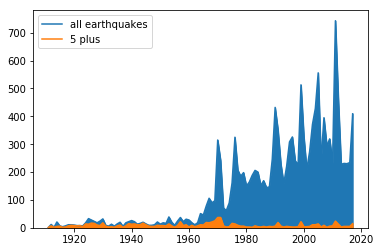

In [35]:
data.year.value_counts().sort_index(ascending=False).plot.area()
data[data.xM >= 5].year.value_counts().sort_index(ascending=False).plot.area()
plt.legend(['all earthquakes', '5 plus'])

Maps are better to comprehend the geologic data. Below you may see the projection of earthquakes with magnitudes more than 5. Seismicly most active areas of Turkey are Aegean Region and Eastern Anatolia. 

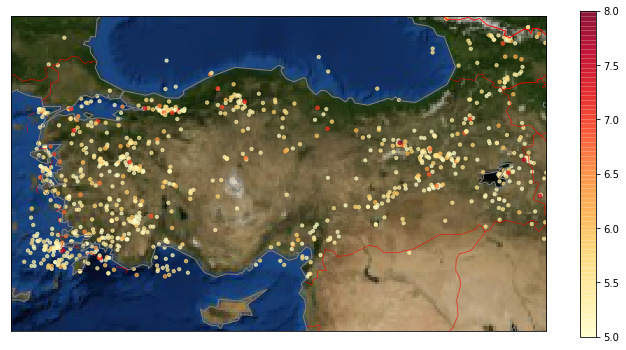

In [36]:
sel = data[data.xM >= 5]
lon = sel['longitude'].values
lat = sel['latitude'].values
xM = sel['xM'].values

fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='lcc', resolution='l', lat_0=39, lon_0=35, width=1.7E6, height=1E6)
m.bluemarble()
m.drawcoastlines(color='gray')
m.drawcountries(color='red')

m.scatter(lon, lat, latlon=True, c=xM, s=xM*2, cmap='YlOrRd', alpha=0.7)

plt.colorbar()
plt.clim(5, 8)